The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

In [17]:

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from gap_statistic import OptimalK
from datetime import datetime
from datetime import date


In [10]:
data= pd.read_excel('/Users/aleksandr/Desktop/rpl_for_model.xlsx')

In [11]:
data['shots on target per 90'] = data['Shots per 90'] * data['Shots on target %']
data['Dribbles succ. per 90'] = data['Dribbles per 90'] * data['Dribbles succ. %']
data['Def duels won per 90'] = data['Def duels per 90'] * data['Def duels won %']
data['Aerial duels won per 90'] = data['Aerial duels per 90'] * data['Aerial duels won %']
data['Tackle succ per 90'] = data['Tackles per 90'] * data['Tackle succ. %']
data['Smt passes acc. per 90'] = data['Smt passes per 90'] * data['Smt passes acc. %']
data['Final 3rd passes acc per90'] = data['Final 3rd passes per 90'] * data['Final 3rd passes acc. %']
data['Thru passes acc per 90'] = data['Thru passes per 90'] * data['Thru passes acc. %']
data['Deep completed passes acc per 90'] = data['Deep completed passes per 90'] * data['Deep completed passes acc. %']
data['Deep completed crosses acc per 90'] = data['Deep completed crosses per 90'] * data['Deep completed crosses acc. %']
data['Passes acc per 90'] = data['Passes per 90'] * data['Passes acc. %']
data['Fwd passes acc per 90'] = data['Fwd passes per 90'] * data['Fwd passes acc. %']
data['Back passes acc'] = data['Back passes per 90'] * data['Back passes acc. %']
data['Lat passes acc'] = data['Lat passes per 90'] * data['Lat passes acc. %']
data['Lng passes acc'] = data['Lng passes per 90'] * data['Lng passes acc. %']


data=data.drop(['xG.1','xA per 90.1', 'xA.1'],axis=1)
data=data[data['Position']!='GK']
data=data[data['Market value']!=0]
player=data['Player']
target=data['Market value']
data=data.drop(['Player', 'Market value', 'Team', 'Matches played', 'Minutes played', 'On loan'],axis=1)

In [12]:
columns_names = []
for col in data.columns:
    columns_names.append(col)
    
cols_no_mean=['Position','Age', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'Height']
columns_names_mean= [x for x in columns_names if x not in cols_no_mean]
for i in data[columns_names_mean]:
    data[i] = data[i].fillna(data[i].mean(), inplace=False)
for i in data[cols_no_mean]:
    data[i] = data[i].fillna(0)    

In [256]:
network_metrics = data.iloc[:,79:103]
#scaler = StandardScaler()
#scaler.fit(network_metrics)
#network_metrics_scaled = scaler.transform(network_metrics)
scaler = MinMaxScaler()  
scaler.fit(network_metrics)
network_metrics_scaled= scaler.transform(network_metrics)

In [19]:
#optimalK = OptimalK(parallel_backend='joblib')
#optimalK
#n_clusters = optimalK(network_metrics_scaled, cluster_array=np.arange(1, 30))

def optimalK(data, nrefs=5, maxClusters=30):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [20]:
k, gapdf = optimalK(network_metrics_scaled, nrefs=5, maxClusters=30)
print(k)

29


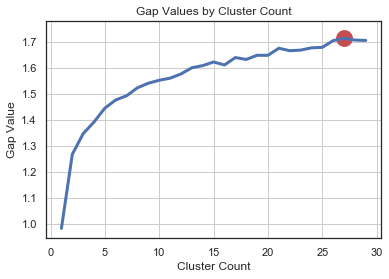

In [259]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [260]:
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=5, random_state=42)
roles_clusters= kmeans.fit_predict(network_metrics_scaled)
data['roles_clusters'] = roles_clusters
data = pd.get_dummies(data, columns=['roles_clusters'])

In [13]:
data['Contract expires'] = data['Contract expires'].replace(0,pd.to_datetime('today') )
data['Contract expires'] = pd.to_datetime(data['Contract expires'])
data['Contract length']= (data['Contract expires'] - pd.to_datetime('today')).astype('timedelta64[D]')
data['Contract length'] = data['Contract length'].replace(-1, 0)
data = data.drop(['Contract expires'],axis=1)

In [14]:
def recode_nation(column):
    if column == 'Russia':
        return 1
    if column == 'Armenia':
        return 1
    if column == 'Kyrgyzstan':
        return 1
    if column == 'Kazakhstan':
        return 1
    if column == 'Ukraine':
        return 1
    else:
        return 0
    
    
data['Birth country'] =data['Birth country'].apply(recode_nation) 
data['Passport country'] =data['Passport country'].apply(recode_nation)
#data = pd.get_dummies(data, columns=['Position', 'Birth country', 'Passport country', 'Foot'])
data=data.drop(['Position'],axis=1)
data = pd.get_dummies(data, columns=[ 'Birth country', 'Passport country', 'Foot'])

In [16]:
scaler = MinMaxScaler()  
scaler.fit(data)
data_scaled= scaler.transform(data)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


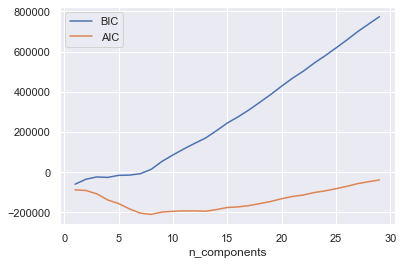

In [28]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(data_scaled) for n in n_components]
plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

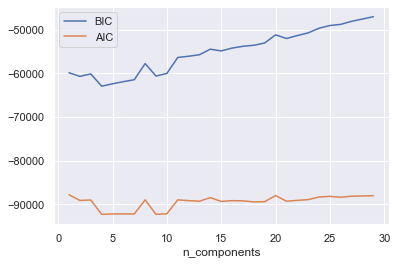

In [40]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='tied', random_state=0).fit(data_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(data_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(data_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [41]:
gmm = GaussianMixture(n_components=20)
gmm.fit(data_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [42]:
labels = gmm.predict_proba(data_scaled)

In [44]:
pd.DataFrame(labels)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
X = data
y = target

In [264]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [265]:
lm = LinearRegression()
lm.fit(X,y)
print(lm.intercept_)
print(lm.coef_)
predictions = lm.predict(X)
r2_score(y,predictions)

31753099.564667024
[-2.12201492e+05 -1.31823185e+05  2.09121441e+05 -2.98738892e+04
  2.41057598e+05  2.06486542e+06  6.49160455e+06  1.74470803e+06
 -6.80512028e+06  1.00226007e+07 -3.66219116e+06  4.13861930e+07
 -1.51647736e+05  1.44208980e+06  5.56680894e+03  2.56241213e+04
 -4.03370724e+05  3.24849619e+06  1.16741903e+06 -2.17509229e+07
 -1.44274473e+05 -6.39611969e+04  2.22285816e+05  6.98422084e+04
  2.32236566e+05 -2.27628486e+05 -1.92041097e+06  4.43113364e+05
  2.81687322e+04  6.45732200e+05  8.73286445e+04  2.28931556e+05
 -2.75035436e+04 -1.01768981e+05 -1.67474219e+06  2.15546408e+06
 -3.44808078e+05  4.48518987e+05  7.00995105e+05 -6.62574731e+06
 -1.57233987e+06  9.29914052e+06  9.33767747e+06  2.30142602e+07
 -2.52662262e+06  2.39501421e+06 -6.56943889e+03  1.23985828e+06
  2.27661861e+06  6.88675154e+04 -1.02536350e+06  4.70431141e+04
 -1.59159784e+06  4.03316926e+04  4.31169299e+05 -4.84105166e+04
  2.70179903e+07  2.07498442e+04 -2.54987120e+05  6.95091991e+05
 -2.93

1.0

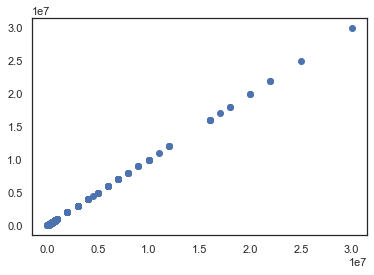

In [271]:
plt.scatter(y,predictions)

Text(0.5, 1.0, 'Linear Regression Model')

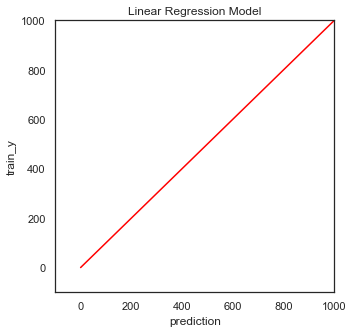

In [269]:

from sklearn import linear_model
plt.figure(figsize=(5, 5))
plt.scatter(y,predictions)
plt.plot( [0,1000],[0,1000], color='red')
plt.xlim(-100, 1000)
plt.ylim(-100, 1000)
plt.xlabel('prediction')
plt.ylabel('train_y')
plt.title('Linear Regression Model')